<a href="https://colab.research.google.com/github/rodmart21/Sports_analytics/blob/main/football_tracking_v5_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Football Players Tracking on a pitch using YOLOv5 + ByteTrack**
## About
In my project, I utilized Roboflow Universe, an open-source computer vision dataset repository with over 100,000 datasets. This platform offered various tools to convert and preprocess data efficiently.

#### Useful links:

* [YOLOv5 repository](https://github.com/ultralytics/yolov5)
* [ByteTrack repository](https://github.com/ifzhang/ByteTrack)
* [Roboflow Notebooks](https://github.com/roboflow/notebooks)


#### Steps Involved:

* Setup<br>
* Download data<br>
* Install YOLOv5<br>
* Install ByteTrack and other libs<br>
* Custom annotator<br>
* Detect ball possession<br>
* Full video tracking<br>
* Put everything together<br>

#### Setup:

In [52]:
!nvidia-smi

Thu May 16 16:33:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              31W /  70W |    415MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [53]:
import os
HOME = os.getcwd()
print(HOME)

/content/yolov5


####Download Data:

In [54]:
!pip install kaggle --upgrade --quiet

I will be using [DFL - Bundesliga Data Shootout](https://www.kaggle.com/competitions/dfl-bundesliga-data-shootout/data) from Kaggle. I will download it using Kaggle API. According to documentation, I need to set up two environment variables first:

    export KAGGLE_USERNAME=datadinosaur


    export KAGGLE_KEY=xxxxxxxxxxxxxx

In [55]:
import os
from getpass import getpass

In [ ]:
os.environ['KAGGLE_USERNAME'] = getpass('Enter KAGGLE_USERNAME secret value: ')
os.environ['KAGGLE_KEY'] = getpass('Enter KAGGLE_KEY secret value: ')

Enter KAGGLE_USERNAME secret value: ··········
Enter KAGGLE_KEY secret value: ··········


In [ ]:
!pip install kaggle

import os
os.environ['KAGGLE_USERNAME'] = "tu_nombre_de_usuario_en_Kaggle"
os.environ['KAGGLE_KEY'] = "tu_API_key_de_Kaggle"

!kaggle competitions download -c dfl-bundesliga-data-shootout


Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 1002, in competition_download_cli
    self.competition_download_files(competition, path, force,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 965, in competition_download_files
    url = response.retries.history[0].redirect_location.split('?')[0]
IndexError: tuple index out of range


In [ ]:
!kaggle competitions files -c dfl-bundesliga-data-shootout | grep clips | head -10

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 900, in competition_list_files_cli
    files = self.competition_list_files(competition)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 875, in competition_list_files
    return [File(f) for f in competition_list_files_result]
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 875, in <listcomp>
    return [File(f) for f in competition_list_files_result]
  File "/usr/local/lib/python3.10/dist-packages/kaggle/models/kaggle_models_extended.py", line 118, in __init__
    parsed_dict = {k: parse(v) for k, v in init_dict.items()}
AttributeError: 'str' object has no attribute 'items'


In [ ]:
%cd {HOME}
!kaggle competitions files -c dfl-bundesliga-data-shootout | \
grep clips | head -20 | \
awk '{print $1}' | \
while read -r line; \
  do kaggle competitions download -c dfl-bundesliga-data-shootout -f $line -p clips --quiet;\
  unzip ${line}.zip -d clips && rm ${line}.zip; \
  done

/content
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 54, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 900, in competition_list_files_cli
    files = self.competition_list_files(competition)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 873, in competition_list_files
    competition_list_files_result = self.process_response(
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 3613, in process_response
    raise Exception(data['message'])
Exception: Unauthorized access


#### Install YOLOv5:

In [56]:
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

import torch
import utils
display = utils.notebook_init()


YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.1/78.2 GB disk)


#### Use pre-trained COCO model

In [57]:
%cd {HOME}/yolov5
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source {HOME}/clips/08fd33_1.mp4 --name coco


/content/yolov5/yolov5
detect: weights=['yolov5x.pt'], source=/content/yolov5/clips/08fd33_1.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=coco, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

100% 166M/166M [00:00<00:00, 290MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Traceback (most recent call last):
  File "/content/yolov5/yolov5/detect.py", line 312, in <module>
    main(opt)
  File "/content/yolov5/yolov5/detect.py", line 307, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib

In [ ]:
# %cd {HOME}/yolov5
# !python detect.py --weights yolov5x6.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_4.mp4 --name coco

#### Use custom model
This model was trained using [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset.

In [58]:
%cd {HOME}
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I" -O best.pt && rm -rf /tmp/cookies.txt

/content/yolov5
--2024-05-16 16:34:05--  https://docs.google.com/uc?export=download&confirm=&id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I
Resolving docs.google.com (docs.google.com)... 74.125.142.101, 74.125.142.100, 74.125.142.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I&export=download [following]
--2024-05-16 16:34:05--  https://drive.usercontent.google.com/download?id=1OYwrlRti4cieuvVr8ERaJhTQdFJXWT4I&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.203.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.203.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2419 (2.4K) [text/html]
Saving to: ‘best.pt’

best.pt             100%[===================>]   2.36K  --.-KB/s   

In [59]:
WEIGHTS_PATH = f"{HOME}/best.pt"

In [60]:
%cd {HOME}/yolov5
!python detect.py --weights {HOME}/best.pt --img 1280 --conf 0.25 --source {HOME}/clips/08fd33_1.mp4 --name custom

/content/yolov5/yolov5
detect: weights=['/content/yolov5/best.pt'], source=/content/yolov5/clips/08fd33_1.mp4, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=custom, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Traceback (most recent call last):
  File "/content/yolov5/yolov5/detect.py", line 312, in <module>
    main(opt)
  File "/content/yolov5/yolov5/detect.py", line 307, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/content/yolov5/yolov5/detect.py", line

#### Use custom model - single frame

In [61]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.imshow(image[...,::-1])
    plt.show()


In [62]:
SOURCE_VIDEO_PATH = f"/content/08fd33_1.mp4"

In [63]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

In [64]:
frame_iterator

<generator object generate_frames at 0x7fc4376d6ff0>

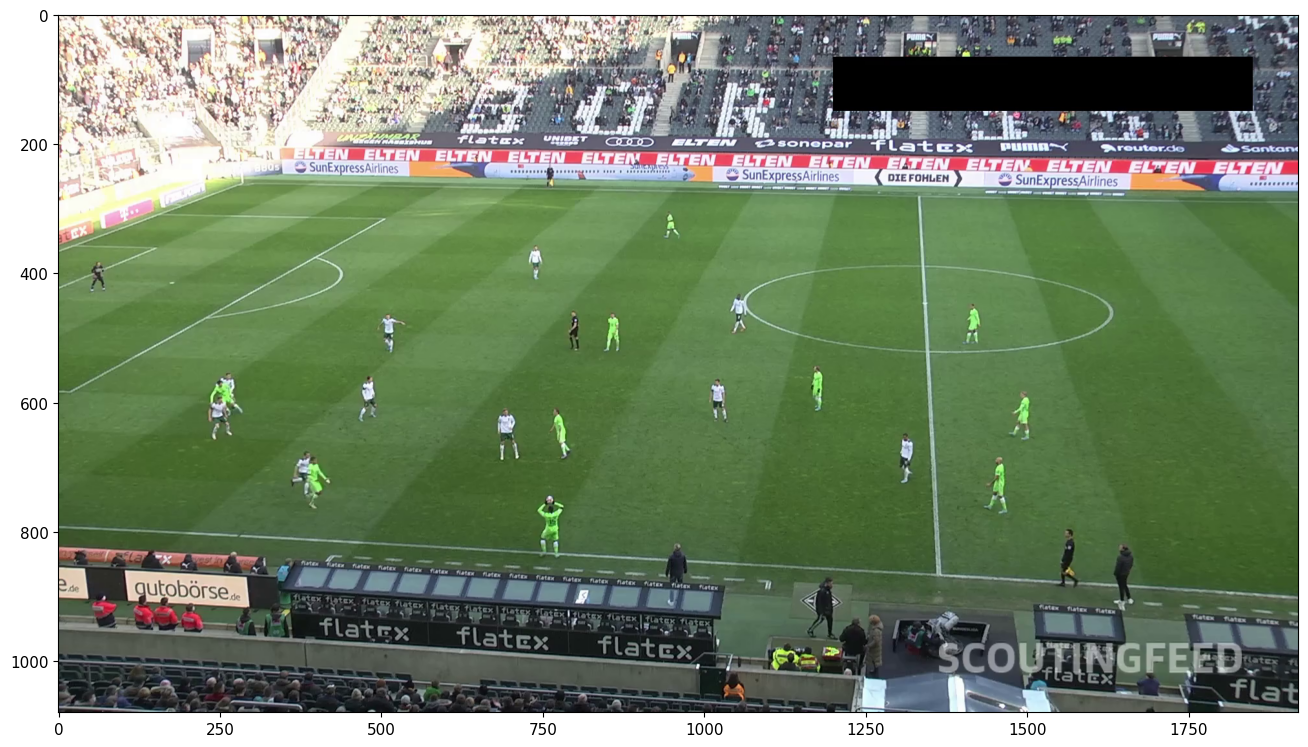

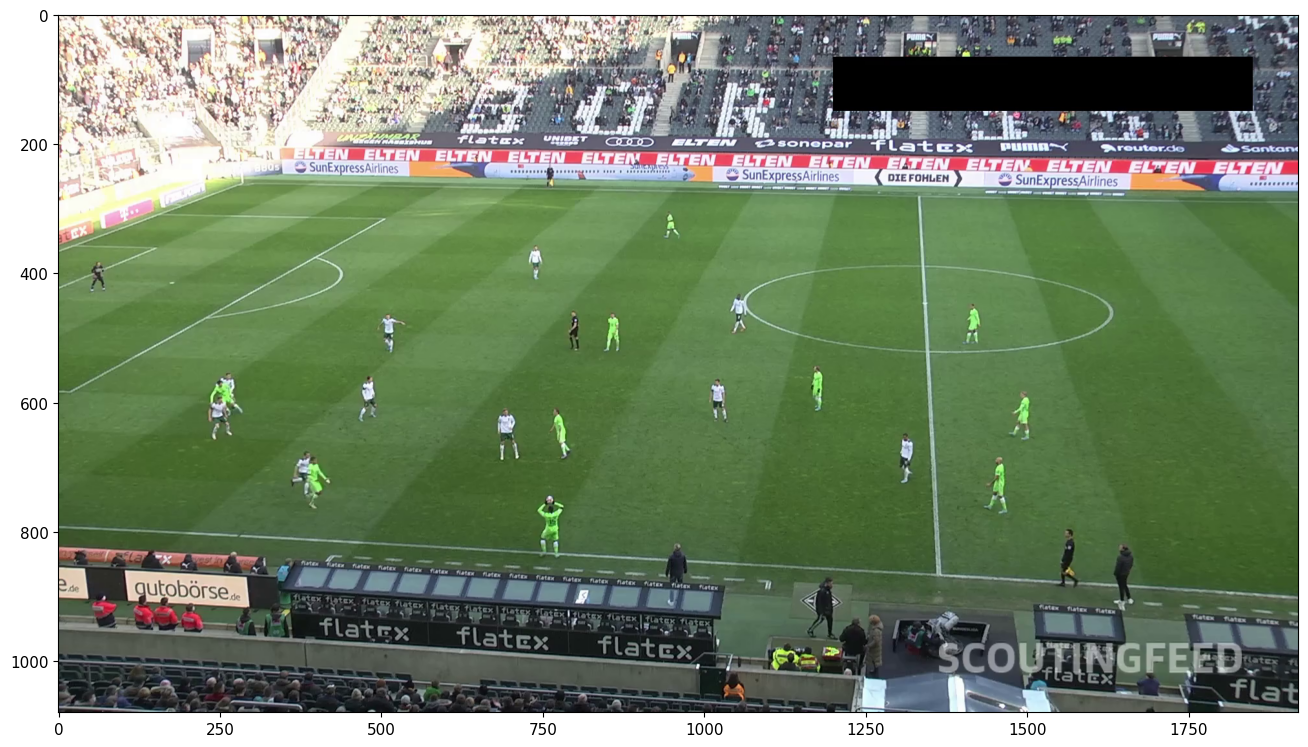

In [65]:
frame = next(frame_iterator)
plot_image(frame, 16)

## Carga del modelo

In [66]:
pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [67]:
pip install -U ultralytics

In [ ]:
import cv2
image=cv2.imread('')

In [70]:
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Image
im = cv2.imread('/content/yolov5/data/images/zidane.jpg')

# Inference
results = model(im)

results.pandas().xyxy[0]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
WARNING ⚠️ NMS time limit 0.550s exceeded


xmin        ymin         xmax        ymax  confidence  class    name
0  743.737305   45.197845  1149.868408  720.000000    0.857245      0  person
1  120.321533  197.517639   853.214722  718.736267    0.620565      0  person
2  439.619598  437.163452   500.712677  711.709717    0.252843     27     tie

In [71]:
WEIGHTS_PATH

'/content/yolov5/best.pt'

In [73]:
results = model(frame, size=1280)

In [74]:
results.pandas()

YOLOv5 <class 'models.common.Detections'> instance
image 1/1: 1080x1920 31 persons
Speed: 14.9ms pre-process, 50.0ms inference, 1.9ms NMS per image at shape (1, 3, 736, 1280)

In [75]:
results.pred[0]

tensor([[7.40340e+02, 7.44294e+02, 7.82997e+02, 8.36756e+02, 8.79581e-01, 0.00000e+00],
        [1.63142e+03, 8.18180e+02, 1.66633e+03, 9.16737e+02, 8.71201e-01, 0.00000e+00],
        [6.78663e+02, 6.09060e+02, 7.14475e+02, 6.93425e+02, 8.57832e-01, 0.00000e+00],
        [7.29195e+02, 3.57646e+02, 7.50707e+02, 4.11932e+02, 8.41815e-01, 0.00000e+00],
        [1.54665e+03, 7.97860e+02, 1.58030e+03, 8.87377e+02, 8.29842e-01, 0.00000e+00],
        [4.64816e+02, 5.60167e+02, 4.95622e+02, 6.28443e+02, 8.26535e-01, 0.00000e+00],
        [4.97589e+02, 4.62372e+02, 5.40744e+02, 5.26341e+02, 8.25888e-01, 0.00000e+00],
        [8.45960e+02, 4.61367e+02, 8.70872e+02, 5.24657e+02, 8.19668e-01, 0.00000e+00],
        [1.04003e+03, 4.31344e+02, 1.06846e+03, 4.94834e+02, 8.15895e-01, 0.00000e+00],
        [1.00953e+03, 5.63563e+02, 1.03569e+03, 6.32609e+02, 8.15578e-01, 0.00000e+00],
        [1.30227e+03, 6.49502e+02, 1.32619e+03, 7.24319e+02, 8.11699e-01, 0.00000e+00],
        [1.47414e+03, 5.83914e+0

In [76]:
model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

#### Install ByteTrack and other libraries
ByteTrack is great tracker but a bit poorly packaged. We need to jump through some fire hoops to make it work in tandem with YOLOv5.

In [77]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox


/content/yolov5
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007
Receiving objects: 100% (2007/2007), 79.60 MiB | 40.70 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) .

In [78]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

In [79]:
!pip install onemetric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False


In [80]:
!pip install loguru
!pip install lap

  Using cached loguru-0.7.2-py3-none-any.whl (62 kB)
  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628950 sha256=b2e20bd9a17ccf1faf2fd0ed5a04f198aeebf86f332f7d5be4180d0bb66e127b
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


In [81]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

#### Custom annotator

In [82]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Tuple, Optional, List, Dict, Any

import cv2

import numpy as np


# geometry utilities


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)
@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def min_x(self) -> float:
        return self.x

    @property
    def min_y(self) -> float:
        return self.y

    @property
    def max_x(self) -> float:
        return self.x + self.width

    @property
    def max_y(self) -> float:
        return self.y + self.height

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

    @property
    def top_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y)

    @property
    def center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height / 2)

    def pad(self, padding: float) -> Rect:
        return Rect(
            x=self.x - padding,
            y=self.y - padding,
            width=self.width + 2*padding,
            height=self.height + 2*padding
        )

    def contains_point(self, point: Point) -> bool:
        return self.min_x < point.x < self.max_x and self.min_y < point.y < self.max_y


# detection utilities


@dataclass
class Detection:
    rect: Rect
    class_id: int
    class_name: str
    confidence: float
    tracker_id: Optional[int] = None

    @classmethod
    def from_results(cls, pred: np.ndarray, names: Dict[int, str]) -> List[Detection]:
        result = []
        for x_min, y_min, x_max, y_max, confidence, class_id in pred:
            class_id=int(class_id)
            result.append(Detection(
                rect=Rect(
                    x=float(x_min),
                    y=float(y_min),
                    width=float(x_max - x_min),
                    height=float(y_max - y_min)
                ),
                class_id=class_id,
                class_name=names[class_id],
                confidence=float(confidence)
            ))
        return result

def filter_detections_by_class(detections: List[Detection], class_name: str) -> List[Detection]:
    return [
        detection
        for detection
        in detections
        if detection.class_name == class_name
    ]


# draw utilities


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

    @classmethod
    def from_hex_string(cls, hex_string: str) -> Color:
        r, g, b = tuple(int(hex_string[1 + i:1 + i + 2], 16) for i in (0, 2, 4))
        return Color(r=r, g=g, b=b)


def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image


def draw_filled_rect(image: np.ndarray, rect: Rect, color: Color) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, -1)
    return image
def draw_polygon(image: np.ndarray, countour: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, thickness)
    return image


def draw_filled_polygon(image: np.ndarray, countour: np.ndarray, color: Color) -> np.ndarray:
    cv2.drawContours(image, [countour], 0, color.bgr_tuple, -1)
    return image


def draw_text(image: np.ndarray, anchor: Point, text: str, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.putText(image, text, anchor.int_xy_tuple, cv2.FONT_HERSHEY_SIMPLEX, 0.7, color.bgr_tuple, thickness, 2, False)
    return image


def draw_ellipse(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.ellipse(
        image,
        center=rect.bottom_center.int_xy_tuple,
        axes=(int(rect.width), int(0.35 * rect.width)),
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color.bgr_tuple,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
    return image


# base annotator
@dataclass
class BaseAnnotator:
    colors: List[Color]
    thickness: int

    def annotate(self, image: np.ndarray, detections: List[Detection]) -> np.ndarray:
        annotated_image = image.copy()
        for detection in detections:
            annotated_image = draw_ellipse(
                image=image,
                rect=detection.rect,
                color=self.colors[detection.class_id],
                thickness=self.thickness
            )
        return annotated_image


In [83]:
# white
BALL_COLOR_HEX = "#FFFFFF"
BALL_COLOR = Color.from_hex_string(BALL_COLOR_HEX)

# red
GOALKEEPER_COLOR_HEX = "#850101"
GOALKEEPER_COLOR = Color.from_hex_string(GOALKEEPER_COLOR_HEX)

# green
PLAYER_COLOR_HEX = "#00D4BB"
PLAYER_COLOR = Color.from_hex_string(PLAYER_COLOR_HEX)

# yellow
REFEREE_COLOR_HEX = "#FFFF00"
REFEREE_COLOR = Color.from_hex_string(REFEREE_COLOR_HEX)

COLORS = [
    BALL_COLOR,
    GOALKEEPER_COLOR,
    PLAYER_COLOR,
    REFEREE_COLOR
]
THICKNESS = 4

In [84]:
# get fresh video frame generator
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_PATH))

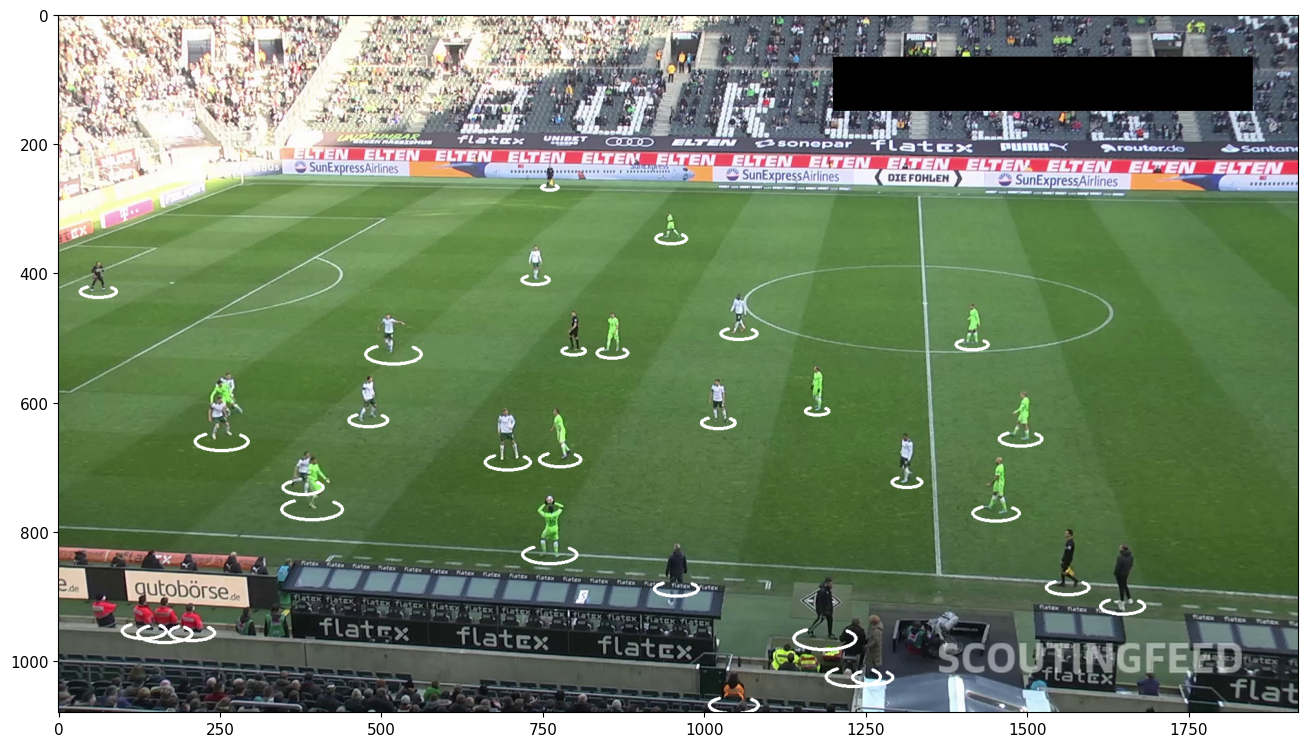

In [85]:
# initiate annotators
annotator = BaseAnnotator(
    colors=COLORS,
    thickness=THICKNESS)

# acquire video frame
frame = next(frame_iterator)

# run detector
results = model(frame, size=1280)
detections = Detection.from_results(
    pred=results.pred[0].cpu().numpy(),
    names=model.names)

# annotate video frame
annotated_image = annotator.annotate(
    image=frame,
    detections=detections)

# plot video frame
plot_image(annotated_image, 16)
